In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go

1) Обучение модели

In [2]:
#Cars
file1 = np.loadtxt('dataset/car/car1.txt')
file2 = np.loadtxt('dataset/car/car2.txt')
file3 = np.loadtxt('dataset/car/car3.txt')
file4 = np.loadtxt('dataset/car/car4.txt')
file5 = np.loadtxt('dataset/car/car5.txt')
file6 = np.loadtxt('dataset/car/car6.txt')

#Trees
file7 = np.loadtxt('dataset/tree/tree1.txt')
file8 = np.loadtxt('dataset/tree/tree2.txt')
file9 = np.loadtxt('dataset/tree/tree3.txt')
file10 = np.loadtxt('dataset/tree/tree4.txt')

models = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
models_string = {
    0: 'Car',
    1: 'Tree'
}
print(file1)

[[ 7.034995 79.224858 93.870559 ...  0.539957 -0.597287  0.593038]
 [ 7.098444 79.780007 93.875917 ...  0.456963  0.289398  0.84109 ]
 [ 7.134974 79.691908 93.877415 ...  0.472569  0.285533  0.833756]
 ...
 [ 4.823397 80.592753 93.661361 ... -0.358866  0.75337   0.551043]
 [ 6.585719 78.939561 93.635603 ... -0.459409  0.824674  0.329935]
 [ 3.15475  79.762764 93.800264 ... -0.842444  0.428417  0.326722]]


In [3]:
#По координатам расчитывает параметры для каждого объекта
def parametrs(file_array):
    file = file_array[:,:6]
    n = len(file)
    
    dispersion_z = sum((file[:,2] - min(file[:,2])) ** 2)/n
    v = (max(file[:,0]) - min(file[:,0]))*(max(file[:,1]) - min(file[:,1]))*(max(file[:,2]) - min(file[:,2]))
    delta_x = max(file[:,0]) - min(file[:,0])
    delta_y = max(file[:,1]) - min(file[:,1])
    delta_z = max(file[:,2]) - min(file[:,2])
    array = np.array([[dispersion_z, v, delta_x, delta_y, delta_z]])
    return array

In [4]:
#Показывает на примере, для чего нужнен алгоритм веявления параметров
print(parametrs(np.loadtxt('dataset/car/car1.txt')))
print(parametrs(np.loadtxt('dataset/tree/tree1.txt')))

[[ 0.65625656 15.37526268  4.619171    2.741471    1.214157  ]]
[[ 135.97722397 2892.90394088   13.411913     12.35253      17.461734  ]]


In [5]:
#Обучение с учителем: алгоритм Наивный Байес

#test_array = df.to_numpy()
teaching = np.concatenate((parametrs(file1), parametrs(file2), parametrs(file3), parametrs(file4), parametrs(file5), parametrs(file6), parametrs(file7), parametrs(file8), parametrs(file9), parametrs(file10)), axis=0)

def Gaus(teaching, models):
    # X - [[признаки], [признаки], [], ...]
    # y - [[вид1], [вид2], [вид3], ...]

    model = GaussianNB()
    model.fit(teaching, models)
    
    return model

model = Gaus(teaching, models)

In [6]:
#Функция проверки класификации объекта
def check(model, test_array):
    predicted = model.predict(test_array)
    return predicted

2) Кластеризация сцены

In [7]:
PointsMin = 15 #минимальное количество точек в объекте

centers_all = np.loadtxt('scene.txt')

#Понижаем размерность до 2 координат (нужно для кластеризации)
centers = centers_all[:,:2]
#print('Переменная centers', centers_all)
#print('Количество строк:', len(centers_all))
#print()

X, labels_true = make_blobs(n_samples=len(centers), centers=centers, cluster_std=0.4, random_state=0) #n_samples эта фича сегментирует точки
X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=PointsMin).fit(X) #eps Максимальное расстояние между двумя образцами для одного должно 
#рассматриваться как соседство с другим. Это не максимальная граница расстояний между точками в кластере. 
#Это наиболее важный параметр DBSCAN, который необходимо выбрать в соответствии с вашим набором данных и функцией расстояния., 
#min_samples Количество выборок (или общий вес) в окрестности для точки, которая должна рассматриваться как основная точка. Это включает в себя саму точку.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) #считает количество кластеров
n_noise_ = list(labels).count(-1) #считает количество точкех как шумами

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))


[0 0 0 ... 0 0 0]
Estimated number of clusters: 1
Estimated number of noise points: 181
Homogeneity: 0.023
Completeness: 1.000
V-measure: 0.045
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


In [8]:
#Количество шума и точек в объектах
KolVoClasters = {}
for i in labels:
    try:
        KolVoClasters[i] += 1
    except:
        KolVoClasters[i] = 1
KolVoClasters

{0: 3696, -1: 181}

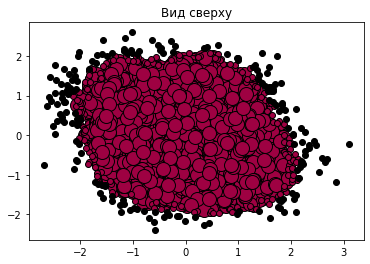

In [9]:
#Рисует сцену на 2D плоскости

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Вид сверху')
plt.show()

In [10]:
# Красные - точки объекта, черные - шум
# centers_all = [[x, y, z, r, b, g], ...]
# labels = [-1, 0, 1, ...]

In [11]:
#Разбиваем множество точек на объекты (опирааясь на вышепроводимую кластеризацию)
claster_object = [[]]*(len(KolVoClasters)-1)
for i in range(len(labels)):
    value_labers = labels[i] # -1, 0 or 1
    point = centers_all[i] # [x, y, z, r, g, b]
    if value_labers != -1:
        claster_object[value_labers].append(point)

# claster_object[0] - numpy.array точек объекта 1
# claster_object[1] - numpy.array точек объекта 2
# claster_object[2] - numpy.array точек объекта 3

In [12]:
#Функция рендеринга моделея объектов
def rendering_models(x_coords, y_coords, z_coords, clasif_name, name):
    fig1 = go.Scatter3d(x=x_coords,
                        y=y_coords,
                        z=z_coords,
                        marker=dict(opacity=0.9,
                                    reversescale=True,
                                    colorscale='Blues',
                                    size=5),
                        line=dict (width=0.02),
                        mode='markers')

    #Make Plot.ly Layout
    mylayout = go.Layout(scene=dict(xaxis=dict(title="X"),
                                    yaxis=dict(title="Y"),
                                    zaxis=dict(title=clasif_name)),)

    #Plot and save html
    plotly.offline.plot({"data": [fig1],
                         "layout": mylayout},
                         auto_open=True,
                         filename=(f"{name}Plot.html"))

In [13]:
#Классификация 1 объекта
test_array = np.array(claster_object[0])
i = check(model, parametrs(test_array))
print(i)
models_name = models_string[i[0]]
print()
print('Это:', models_name)

[0]

Это: Car


In [14]:
#Построение 1 объекта
rendering_models(test_array[:][:,0], test_array[:][:,1], test_array[:][:,2], models_name, str(i))

3) Еще не реализовано

In [ ]:
#Классификация 2 объекта
test_array = np.loadtxt('dataset/car/car8.txt')
i = check(model, parametrs(test_array))
models_name = models_string[i[0]]
print('Это:', models_name)

In [ ]:
#Построение 2 объекта
rendering_models(np.array(claster_object[1])[:][:,0], np.array(claster_object[1])[:][:,1], np.array(claster_object[1])[:][:,2], models_name, str(i))